In [1]:
import sys
from pathlib import Path

lib_path: str = (Path.cwd().parents[1] / "lib").as_posix()
if lib_path not in sys.path:
    sys.path.insert(1, lib_path)

In [2]:
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from Evaluator import Evaluator
from pathlib import Path

In [3]:
class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]

    def __setattr__(self, attr, value):
        self[attr] = value

# Usage
ROOT_DIR = Path.cwd().parent / "data" / "owl2vec"
FLAGS = AttributeDict()
FLAGS['train_file'] =  ROOT_DIR / "train.csv"
FLAGS['valid_file'] =  ROOT_DIR / "valid.csv"
FLAGS['test_file'] =  ROOT_DIR / "test.csv"
FLAGS['class_file'] =  ROOT_DIR / "classes.txt"
FLAGS['inferred_ancestor_file'] =  ROOT_DIR / "inferred_ancestors.txt"
FLAGS["input_type"] ="concatenate"

In [4]:
TRAIN_PATH = Path.cwd().parent / 'data' / 'FoodOn' /'train_dataset.tsv'
# MODEL_PATH = Path.cwd() / "save_owl2vec_weights" / "OWL2VEC.csv"
MODEL_PATH = Path.cwd() / 'save_pykeen_weights' / 'pykeen_weights.pkl'

# Save and Load

In [5]:
if MODEL_PATH.suffix == ".csv":
    classes = [line.strip() for line in open(FLAGS.class_file).readlines()]
    classes_dict = {cls: i for i, cls in enumerate(classes)}
    classes_e = pd.read_csv(MODEL_PATH, header=None).to_numpy()
    
elif MODEL_PATH.suffix == ".pkl":
    info = pickle.load(open(MODEL_PATH, "rb"))
    classes_dict = info["entities_to_id"]
    classes_e = info["embedded_vectors"]
    classes = list(classes_dict.keys())

In [6]:
triples = pd.read_csv(TRAIN_PATH, header=None, names=['head', 'relation', 'tail'])

new_embedsize = classes_e[0].shape[0]
candidate_num = len(classes)

# 2.Train and test

In [7]:
train_samples = [line.strip().split(',') for line in open(FLAGS.train_file).readlines()]
valid_samples = [line.strip().split(',') for line in open(FLAGS.valid_file).readlines()]
test_samples = [line.strip().split(',') for line in open(FLAGS.test_file).readlines()]
random.shuffle(train_samples)



In [8]:
train_x_list, train_y_list = list(), list()
for s in tqdm(train_samples):
    sub, sup, label = s[0], s[1], s[2]
    sub_v = classes_e[classes_dict[sub]]
    sup_v = classes_e[classes_dict[sup]]
    if not (np.all(sub_v == 0) or np.all(sup_v == 0)):
        if FLAGS.input_type == 'concatenate':
            train_x_list.append(np.concatenate((sub_v, sup_v)))
        else:
            train_x_list.append(sub_v - sup_v)
        train_y_list.append(int(label))
train_X, train_y = np.array(train_x_list), np.array(train_y_list)
print('train_X: %s, train_y: %s' % (str(train_X.shape), str(train_y.shape)))

100%|██████████| 41688/41688 [00:00<00:00, 67269.04it/s]

train_X: (41688, 200), train_y: (41688,)


In [9]:
inferred_ancestors = dict()
with open(FLAGS.inferred_ancestor_file) as f:
    for line in f.readlines():
        all_infer_classes = line.strip().split(',')
        cls = all_infer_classes[0]
        inferred_ancestors[cls] = all_infer_classes

# Inclusion Evaluation

In [10]:
class InclusionEvaluator(Evaluator):
    def __init__(self, valid_samples, test_samples, train_X, train_y):
        super(InclusionEvaluator, self).__init__(valid_samples, test_samples, train_X, train_y)

    def evaluate(self, model, eva_samples):
        MRR_sum, hits1_sum, hits5_sum, hits10_sum = 0, 0, 0, 0
        random.shuffle(eva_samples)
        tqdm_data = tqdm(eva_samples)
        for num, sample in enumerate(tqdm_data, start = 1):
            sub, gt = sample[0], sample[1]
            sub_index = classes_dict[sub]
            sub_v = classes_e[sub_index]
            if FLAGS.input_type == 'concatenate':
                X = np.concatenate((np.array([sub_v] * candidate_num), classes_e), axis=1)
            else:
                X = np.array([sub_v] * candidate_num) - classes_e
            P = model.predict_proba(X)[:, 1]
            sorted_indexes = np.argsort(P)[::-1]
            sorted_classes = list()
            for j in sorted_indexes:
                if classes[j] not in inferred_ancestors[sub]:
                    sorted_classes.append(classes[j])
            rank = sorted_classes.index(gt) + 1
            MRR_sum += 1.0 / rank
            hits1_sum += 1 if gt in sorted_classes[:1] else 0
            hits5_sum += 1 if gt in sorted_classes[:5] else 0
            hits10_sum += 1 if gt in sorted_classes[:10] else 0
            tqdm_data.set_description('MRR: %.4f, Hits@1: %.4f, Hits@5: %.4f, Hits@10: %.4f' %
                      (MRR_sum/num, hits1_sum/num, hits5_sum/num, hits10_sum/num))
        eva_n = len(eva_samples)
        e_MRR, hits1, hits5, hits10 = MRR_sum / eva_n, hits1_sum / eva_n, hits5_sum / eva_n, hits10_sum / eva_n
        return e_MRR, hits1, hits5, hits10

In [12]:
print("\n		2.Train and test ... \n") # test on test_samples
evaluator = InclusionEvaluator(valid_samples, test_samples[:10], train_X, train_y)
evaluator.run_random_forest()


		2.Train and test ... 



MRR: 0.0271, Hits@1: 0.0000, Hits@5: 0.1000, Hits@10: 0.1000: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it]

Testing, MRR: 0.027, Hits@1: 0.000, Hits@5: 0.100, Hits@10: 0.100




# Concept2Vec

In [11]:
from concept2vec import run_concept2vec_evaluation

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

train_samples_df = pd.DataFrame(train_samples, columns=['individual', 'class', 'label'])
sample_tsne_classes = list(train_samples_df[train_samples_df['label'] == '1']["class"].value_counts().head(10).index)

http://www.w3.org/2002/07/owl#Class    28182
Name: count, dtype: int64
No concepts found
Distance in the embedding space of training samples


  0%|          | 0/41688 [00:00<?, ?it/s]d:\.VScode/projects/Owls2Vec_star/ontology_evaluator/lib\concept2vec.py:226: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = average_distance[1] / average_distance[0]
100%|██████████| 41688/41688 [00:00<00:00, 58252.86it/s]


average_distance:
positive: 0.629
negative: 0.703
ratio 0.895


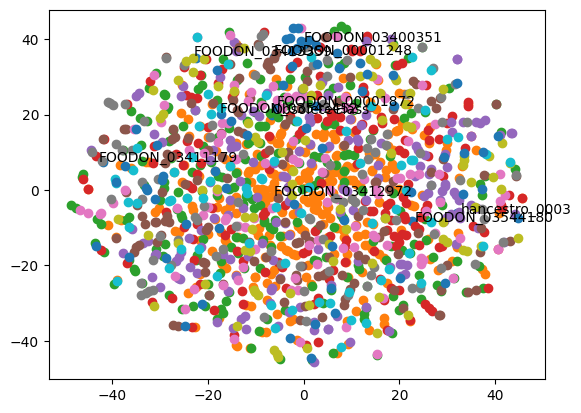

KeyboardInterrupt: 

In [12]:
run_concept2vec_evaluation(
    triples = triples.values,
    entity_to_id = classes_dict, 
    embedded_vectors = classes_e,
    coherence_top_k = 10,
    train_samples = train_samples,
    tsne_classes = sample_tsne_classes
)

# For Owl2Vec This should get KeyError: 'http://www.w3.org/2002/07/owl#Class' as the owl2vec not save this class with http://www.w3.org/2002/07/owl#ObjectProperty class

# Semantic-aligned Evaluation

In [15]:
from semantic_eval import SemMR, SemMRR
SEM_DATA_PATH = Path.cwd().parent / 'data' / 'semantic' / 'food_on_filtered_subsumption_dataset.pkl'
with open(SEM_DATA_PATH, "rb") as f:
    testable_dataset = pickle.load(f)

In [16]:
class ontologyEvaluator(Evaluator):
    def __init__(self, valid_samples, test_samples, train_X, train_y):
        super(ontologyEvaluator, self).__init__(valid_samples, test_samples, train_X, train_y)

    def evaluate(self, model, eva_samples):
        tracking_semrr = tracking_semr = 0
        tqdm_data = tqdm(eva_samples)
        for ind, data in enumerate(tqdm_data, start = 1):
            sub = data[0]
            sub_index = classes_dict[sub]
            sub_v = classes_e[sub_index]
            if FLAGS.input_type == 'concatenate':
                X = np.concatenate((np.array([sub_v] * candidate_num), classes_e), axis=1)
            else:
                X = np.array([sub_v] * candidate_num) - classes_e
            P = model.predict_proba(X)[:, 1]
            sorted_indexes = np.argsort(P)[::-1]
            proposed_sequence = [classes[j] for j in sorted_indexes]
            
            semmr = SemMR(proposed_sequence, data[1:])
            semmrr = SemMRR(proposed_sequence, data[1:])
            
            tracking_semrr += semmrr
            tracking_semr += semmr
            tqdm_data.set_description(f"SemMR: {tracking_semr/ind:.4f}, SemMRR: {tracking_semrr/ind:.4f}")
            
        eva_n = len(eva_samples)
        return {
            "SeMR": tracking_semr / eva_n, 
            "SeMRR": tracking_semrr / eva_n
            }

In [18]:
print("\n		2.Train and test ... \n")
ontology_evaluator = ontologyEvaluator(None, None, None, None)
ontology_evaluator.evaluate(evaluator.best_model, testable_dataset[:10])


		2.Train and test ... 



SemMR: 1970482.1000, SemMRR: 0.3647: 100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


{'SeMR': 1970482.1, 'SeMRR': 0.36469061692981264}